## Creating a function to time our experiments and setup helper_functions.py


In [1]:
from timeit import default_timer as timer
import torch

def print_train_time(start:float, end:float, device:torch.device=None):
   total_time= end - start
   print(f"Train time on {device}: {total_time:.3f} seconds")
   return total_time



In [2]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


## 1. Installation, Data Loading and Preparation

In [41]:
import torch 
from torch import nn
from torchvision import transforms
import torchvision
from torchvision import datasets
from torchvision.transforms import Compose,ToTensor,Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt 
from helper_functions import accuracy_fn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from PIL import Image
import requests


device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_data=datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),Normalize((.5,.5,.5),(.5,.5,.5))]),
)

test_data=datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(),Normalize((.5,.5,.5),(.5,.5,.5))])
)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [4]:
BATCH_SIZE=32

train_dataloader=DataLoader(train_data,
                            batch_size=BATCH_SIZE,
																												shuffle=True
																												)

test_dataloader=DataLoader(test_data,
                            batch_size=BATCH_SIZE,
																												shuffle=False
																												)

print(f"Dataloader:{train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

train_features_batch, train_labels_batch=next(iter(train_dataloader))
print(f"\nImage batch shape: {train_features_batch.shape}")
print(f"Label batch shape: {train_labels_batch.shape}")



Dataloader:(<torch.utils.data.dataloader.DataLoader object at 0x000002051E26A1D0>, <torch.utils.data.dataloader.DataLoader object at 0x000002051E26BA10>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32

Image batch shape: torch.Size([32, 3, 32, 32])
Label batch shape: torch.Size([32])


### Visualise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7411765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clip

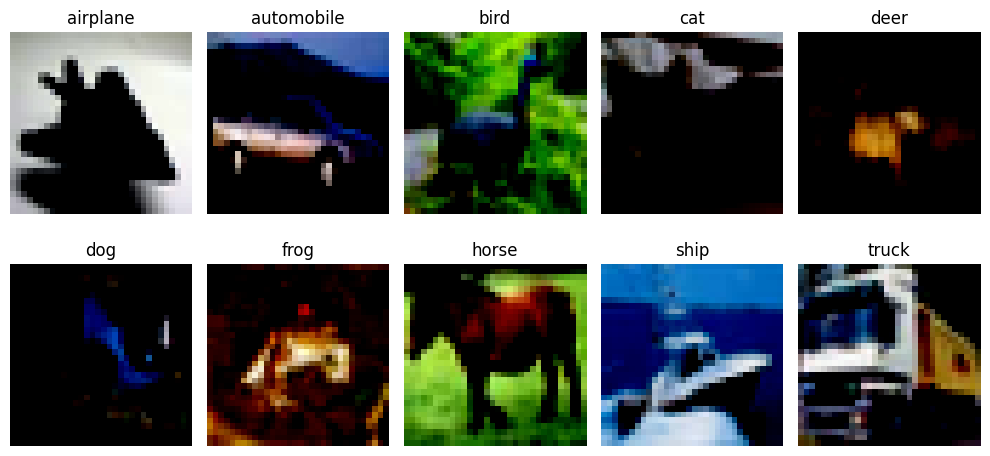

In [5]:
classes = train_data.classes

images_per_class = []
for class_idx in range(10):
    for img, label in train_data:
        if label == class_idx:
            images_per_class.append((img, label))
            break


fig = plt.figure(figsize=(10, 5))
for i, (img, label) in enumerate(images_per_class):
    img = img.permute(1, 2, 0)
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


## 2. Baseline Model (Model_0) and Training

In [6]:
class CIFAR10MODELV0(nn.Module):
    def __init__(self,in_shape:int,hidden_units:int,out_shape):
        super().__init__()
        self.layer_stack=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=out_shape)
								)
    def forward(self,x:torch.Tensor):
        return self.layer_stack(x)

torch.manual_seed(31)
model_0=CIFAR10MODELV0(in_shape=3*32*32,
                       hidden_units=64,
                       out_shape=len(train_data.classes)
																							).to(device)
print(model_0)
print(model_0.state_dict())

CIFAR10MODELV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)
OrderedDict([('layer_stack.1.weight', tensor([[-0.0098, -0.0028, -0.0081,  ...,  0.0096, -0.0136,  0.0002],
        [-0.0052, -0.0172, -0.0051,  ..., -0.0030,  0.0145,  0.0166],
        [ 0.0011, -0.0134,  0.0113,  ..., -0.0098,  0.0067, -0.0011],
        ...,
        [ 0.0087, -0.0123,  0.0166,  ...,  0.0059,  0.0017,  0.0084],
        [ 0.0086,  0.0102, -0.0085,  ..., -0.0116, -0.0048, -0.0067],
        [ 0.0023,  0.0150, -0.0132,  ...,  0.0123,  0.0120,  0.0141]],
       device='cuda:0')), ('layer_stack.1.bias', tensor([-0.0116,  0.0016,  0.0134,  0.0003, -0.0157,  0.0002, -0.0162, -0.0032,
         0.0028,  0.0175,  0.0097,  0.0024, -0.0030,  0.0027,  0.0054,  0.0011,
        -0.0069,  0.0054, -0.0095, -0.0033,  0.0140,  0.0077,  0.0139, -0.0147,
        

In [7]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_0.parameters(),lr=.001)
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        if batch %400==0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


torch.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end_time = timer()
total_train_time_model_1 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)

Epoch: 0
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.66572 | Train accuracy: 41.25%
Test loss: 1.54348 | Test accuracy: 44.87%

Epoch: 1
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.48879 | Train accuracy: 47.64%
Test loss: 1.47584 | Test accuracy: 47.25%

Epoch: 2
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.41434 | Train accuracy: 50.22%
Test loss: 1.50285 | Test accuracy: 46.73%

Epoch: 3
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.36523 | Train accuracy: 51.91%
Test loss: 1.43970 | Test accuracy: 49.20%

Epoch: 4
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples

## 3. Baseline Model (Model_1) and Training

In [8]:
class CIFAR10ModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units_2, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)


    
model_1 = CIFAR10ModelV1(input_shape=3072,
                         hidden_units_1=128,
                         hidden_units_2=64,
                         output_shape=10).to(device)

print(model_1)
print(model_1.state_dict())

optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

CIFAR10ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=10, bias=True)
  )
)
OrderedDict([('layer_stack.1.weight', tensor([[ 0.0011, -0.0123,  0.0056,  ...,  0.0145, -0.0008,  0.0139],
        [ 0.0142, -0.0094, -0.0016,  ...,  0.0128,  0.0031,  0.0029],
        [-0.0136,  0.0051, -0.0141,  ...,  0.0093,  0.0019, -0.0065],
        ...,
        [ 0.0017, -0.0029,  0.0063,  ...,  0.0073,  0.0107, -0.0049],
        [ 0.0113,  0.0065,  0.0044,  ...,  0.0031, -0.0074, -0.0088],
        [-0.0095,  0.0030,  0.0165,  ...,  0.0043,  0.0078,  0.0132]],
       device='cuda:0')), ('layer_stack.1.bias', tensor([-3.3794e-03,  1.0541e-03, -7.0920e-03, -1.6055e-03, -3.5415e-03,
         6.8916e-03,  9.5975e-03,  6.4094e-03, -7.3139e-03,  1.1537e-02,
         5.4798e-03, -1.

In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        if batch %400==0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


torch.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer_1,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end_time = timer()
total_train_time_model_1 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)


Epoch: 0
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.64644 | Train accuracy: 41.62%
Test loss: 1.50713 | Test accuracy: 46.54%

Epoch: 1
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.45651 | Train accuracy: 48.50%
Test loss: 1.42575 | Test accuracy: 49.19%

Epoch: 2
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.36251 | Train accuracy: 51.75%
Test loss: 1.41513 | Test accuracy: 50.07%

Epoch: 3
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.29225 | Train accuracy: 54.14%
Test loss: 1.41706 | Test accuracy: 50.09%

Epoch: 4
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples

### Experiment 2 (Model_2) - Adding Dropout

In [10]:
class CIFAR10ModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units_1: int, hidden_units_2: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units_1),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Add Dropout
            nn.Linear(in_features=hidden_units_1, out_features=hidden_units_2),
            nn.ReLU(),
            nn.Dropout(p=0.5), # Add Dropout
            nn.Linear(in_features=hidden_units_2, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = CIFAR10ModelV2(input_shape=3072,
                         hidden_units_1=128,
                         hidden_units_2=64,
                         output_shape=10).to(device)

optimizer_2 = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

In [11]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        if batch %400==0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


torch.manual_seed(42)


from timeit import default_timer as timer
start_time = timer()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer_2,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end_time = timer()
total_train_time_model_1 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)


Epoch: 0
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.95473 | Train accuracy: 29.10%
Test loss: 1.70570 | Test accuracy: 38.73%

Epoch: 1
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.57270 | Train accuracy: 44.00%
Test loss: 1.48176 | Test accuracy: 46.87%

Epoch: 2
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.43927 | Train accuracy: 49.05%
Test loss: 1.45769 | Test accuracy: 48.47%

Epoch: 3
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.34781 | Train accuracy: 52.27%
Test loss: 1.41755 | Test accuracy: 50.68%

Epoch: 4
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples

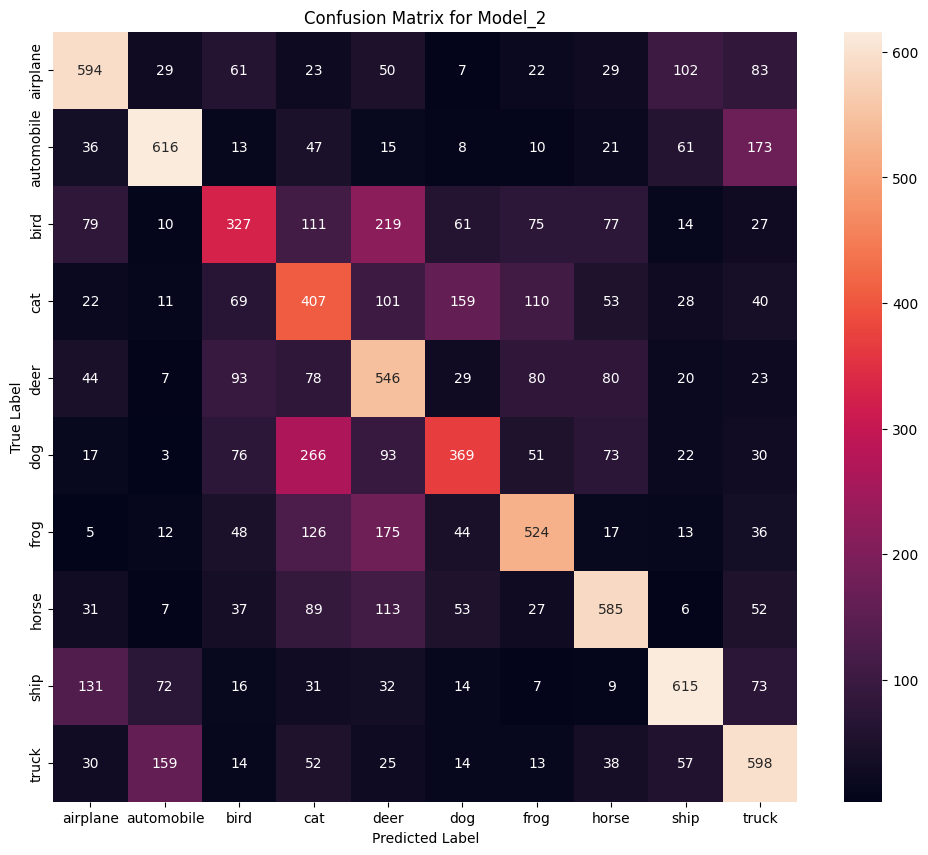

In [29]:
y_preds=[]
y_true=[]

model_2.eval()
with torch.inference_mode():
    for X,y in test_dataloader:
        X,y=X.to(device),y.to(device)
        outputs=model_2(X)
        y_pred_labels=torch.argmax(outputs,dim=1)
        y_preds.extend(y_pred_labels.cpu().numpy())
        y_true.extend(y.cpu().numpy())
        
confmat=confusion_matrix(y_true=y_true,y_pred=y_preds)

plt.figure(figsize=(12,10))
sns.heatmap(
    confmat,
    annot=True,
    fmt="d",
    xticklabels=train_data.classes,
    yticklabels=train_data.classes
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model_2')
plt.show()

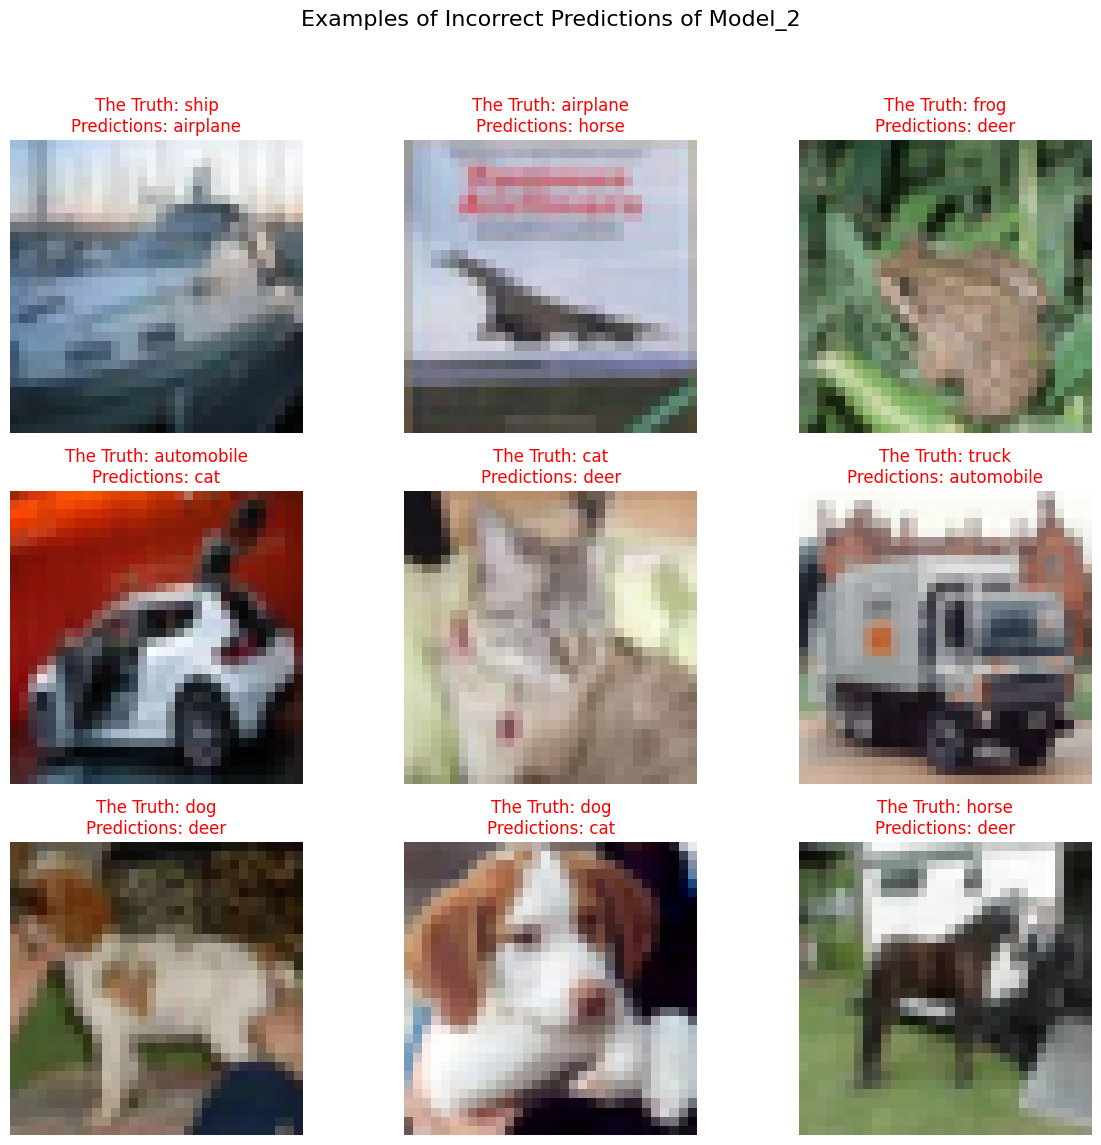

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

incorrect_predictions = []

model_2.eval()
with torch.inference_mode():

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        

        test_logits = model_2(X)
        test_preds = torch.argmax(test_logits, dim=1)
        

        incorrect_indices = torch.where(test_preds != y)[0]
        

        for idx in incorrect_indices:
            incorrect_predictions.append({
                "image": X[idx],
                "true_label": y[idx],
                "pred_label": test_preds[idx]
            })
         #Break the cycle if we have found enough examples (efficiency)
        if len(incorrect_predictions) >= 9:
            break


if len(incorrect_predictions) >= 9:
    pass 


plt.figure(figsize=(12, 12))
plt.suptitle("Examples of Incorrect Predictions of Model_2", fontsize=16)

for i, item in enumerate(incorrect_predictions[:9]):
    plt.subplot(3, 3, i+1)
    
   
    image_to_plot = item["image"].cpu()
    
    # IMPORTANT Correct colours by undoing normalisation
    image_to_plot = image_to_plot * 0.5 + 0.5
    
    #[C, H, W] -> [H, W, C] 
    plt.imshow(image_to_plot.permute(1, 2, 0))
    
   
    true_label_text = train_data.classes[item["true_label"]]
    pred_label_text = train_data.classes[item["pred_label"]]
    plt.title(f"The Truth: {true_label_text}\nPredictions: {pred_label_text}", color="red")
    
    plt.axis(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
train_features_batch.shape

torch.Size([32, 3, 32, 32])

## Build and Train CNN Model

In [15]:
class CIFAR10ModelV_CNN(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), # padding=1, keeps the size the same with 3x3 kernel
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #16x16
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) #8x8
        )
    
        self.classifier = nn.Sequential(
            nn.Flatten(), # Converts the incoming 10x8x8 matrix into a vector of 10*8*8=640
            # in_features calculation: hidden_units * (final height) * (final width)
            nn.Linear(in_features=hidden_units * 8 * 8, 
                      out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model_3 = CIFAR10ModelV_CNN(input_shape=3, # Colour channels
                            hidden_units=10, 
                            output_shape=len(train_data.classes)).to(device)    
print(model_3)
print(model_3.state_dict())

CIFAR10ModelV_CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)
OrderedDict([('conv_block_1.0.weight', tensor([[[[ 0.1471,  0.1597, -0.0451],
          [ 0.1768, -0.0422,  0.0388],
          [-0.0937,  0.1130,  0.1697]],

         [[-0.1412,  0.1673,  0.0360],
          [ 0.1422,  0.0261,  0.0928],
         

In [16]:
# Loos and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_3.parameters(),lr=0.001)


In [17]:
start_time=timer()

epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_3, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_3,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end_time=timer()
total_train_time_model_3=print_train_time(start=start_time,
                                          end=end_time,
                                          device=device)

Epoch: 0
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.57914 | Train accuracy: 43.15%
Test loss: 1.35193 | Test accuracy: 51.03%

Epoch: 1
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.28360 | Train accuracy: 54.51%
Test loss: 1.21666 | Test accuracy: 57.00%

Epoch: 2
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.15373 | Train accuracy: 59.23%
Test loss: 1.11336 | Test accuracy: 61.03%

Epoch: 3
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.07640 | Train accuracy: 62.11%
Test loss: 1.06749 | Test accuracy: 62.38%

Epoch: 4
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples

In [18]:
# Model_4: CNN with more hidden units
torch.manual_seed(42)
model_4=CIFAR10ModelV_CNN(input_shape=3, # Colour channels,
                          hidden_units=50,
                          output_shape=len(train_data.classes)

).to(device)

optimizer_4=torch.optim.Adam(params=model_4.parameters(),lr=0.001)

start_time=timer()

epoch=10

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
               model=model_4,
               loss_fn=loss_fn,
               optimizer=optimizer_4,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_step(
        data_loader=test_dataloader,
        model=model_4,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device

    )

end_time=timer()

total_train_time_model_4=print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)





Epoch: 0
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.28924 | Train accuracy: 54.10%
Test loss: 0.97909 | Test accuracy: 65.98%

Epoch: 1
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.87722 | Train accuracy: 69.43%
Test loss: 0.82336 | Test accuracy: 70.94%

Epoch: 2
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.73202 | Train accuracy: 74.52%
Test loss: 0.77328 | Test accuracy: 73.20%

Epoch: 3
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.64116 | Train accuracy: 77.63%
Test loss: 0.74814 | Test accuracy: 74.21%

Epoch: 4
---------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples

# Taming the Strong Model

In [20]:
class CIFAR10ModelV_CNN_With_Dropout(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,out_features=output_shape)
        )
    
    def forward(self,x):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

torch.manual_seed(42)
model_5=CIFAR10ModelV_CNN_With_Dropout(input_shape=3,
                                        hidden_units=50,
                                        output_shape=len(train_data.classes)
                                       ).to(device)
print(model_5)

CIFAR10ModelV_CNN_With_Dropout(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=10, bias=True)
  )
)


In [25]:
optimizer_5=torch.optim.Adam(params=model_5.parameters(),lr=0.001)
start_time=timer()

epochs=20

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-----------")
    train_step(data_loader=train_dataloader,
                model=model_5,
                optimizer=optimizer_5,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device
               )
    test_step(data_loader=test_dataloader,
              model=model_5,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              
              )
    
end_time=timer()
total_train_time_model_5=print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)


Epoch: 0
-----------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.26330 | Train accuracy: 90.44%
Test loss: 1.01144 | Test accuracy: 74.73%

Epoch: 1
-----------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.22542 | Train accuracy: 91.98%
Test loss: 1.05367 | Test accuracy: 75.48%

Epoch: 2
-----------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.21571 | Train accuracy: 92.35%
Test loss: 1.17921 | Test accuracy: 73.71%

Epoch: 3
-----------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.19809 | Train accuracy: 92.91%
Test loss: 1.22460 | Test accuracy: 73.58%

Epoch: 4
-----------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/500

## Model_6 - CNN + Batch Normalization

In [26]:
class CIFAR10ModelV_CNN_With_BN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, 
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
torch.manual_seed(42)
model_6=CIFAR10ModelV_CNN_With_BN(input_shape=3,
                                  hidden_units=50,
                                  output_shape=len(train_data.classes)
                            ).to(device)

print(model_6)
optimizer_6=torch.optim.Adam(params=model_6.parameters(),lr=0.001)

CIFAR10ModelV_CNN_With_BN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Se

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time=timer()
epochs=10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n------------")
    train_step(data_loader=train_dataloader,
               model=model_6,
               optimizer=optimizer_6,
               loss_fn=loss_fn,
               device=device,
               accuracy_fn=accuracy_fn
               )
    test_step(data_loader=test_dataloader,
              model=model_6,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

end_time = timer()

total_train_time_model_6=print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)




Epoch: 0
------------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 1.17845 | Train accuracy: 58.41%
Test loss: 0.92066 | Test accuracy: 67.49%

Epoch: 1
------------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.82183 | Train accuracy: 71.57%
Test loss: 0.77974 | Test accuracy: 72.64%

Epoch: 2
------------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.68167 | Train accuracy: 76.48%
Test loss: 0.71144 | Test accuracy: 75.46%

Epoch: 3
------------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 25600/50000 samples
Looked at 38400/50000 samples
Train loss: 0.59210 | Train accuracy: 79.63%
Test loss: 0.68757 | Test accuracy: 76.33%

Epoch: 4
------------
Looked at 0/50000 samples
Looked at 12800/50000 samples
Looked at 2560

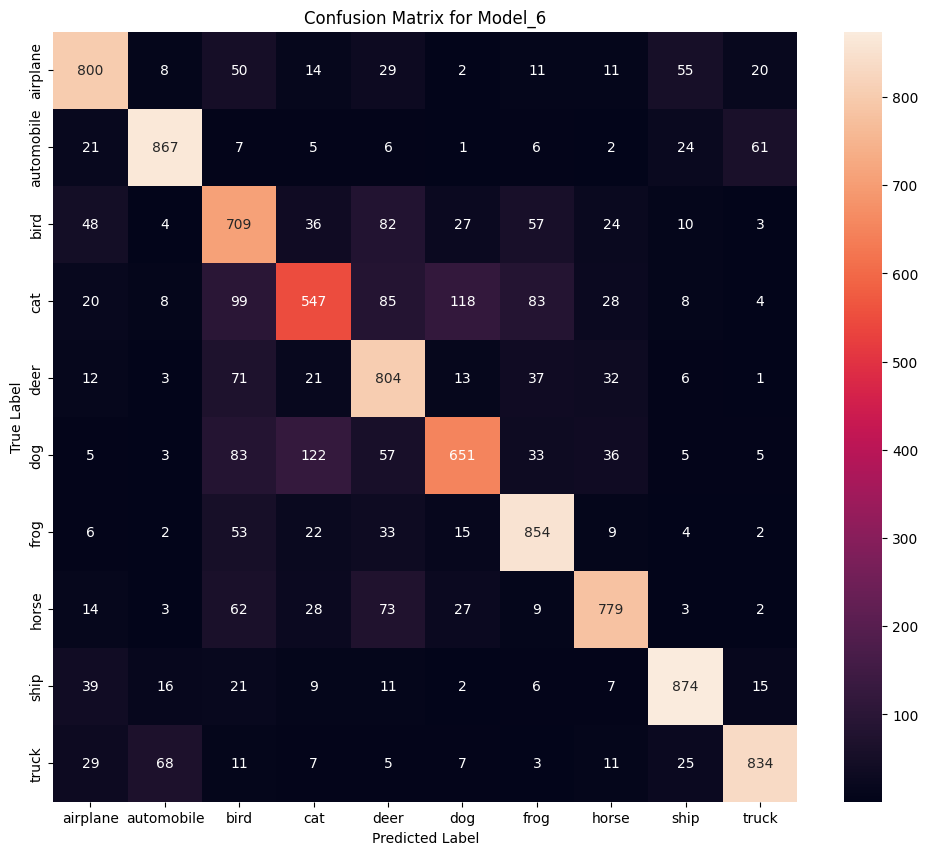

In [31]:
y_preds=[]
y_true=[]

model_6.eval()
with torch.inference_mode():
    for X,y in test_dataloader:
        X,y=X.to(device),y.to(device)
        outputs=model_6(X)
        y_pred_labels=torch.argmax(outputs,dim=1)
        y_preds.extend(y_pred_labels.cpu().numpy())
        y_true.extend(y.cpu().numpy())
        
confmat=confusion_matrix(y_true=y_true,y_pred=y_preds)

plt.figure(figsize=(12,10))
sns.heatmap(
    confmat,
    annot=True,
    fmt="d",
    xticklabels=train_data.classes,
    yticklabels=train_data.classes
)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model_6')
plt.show()

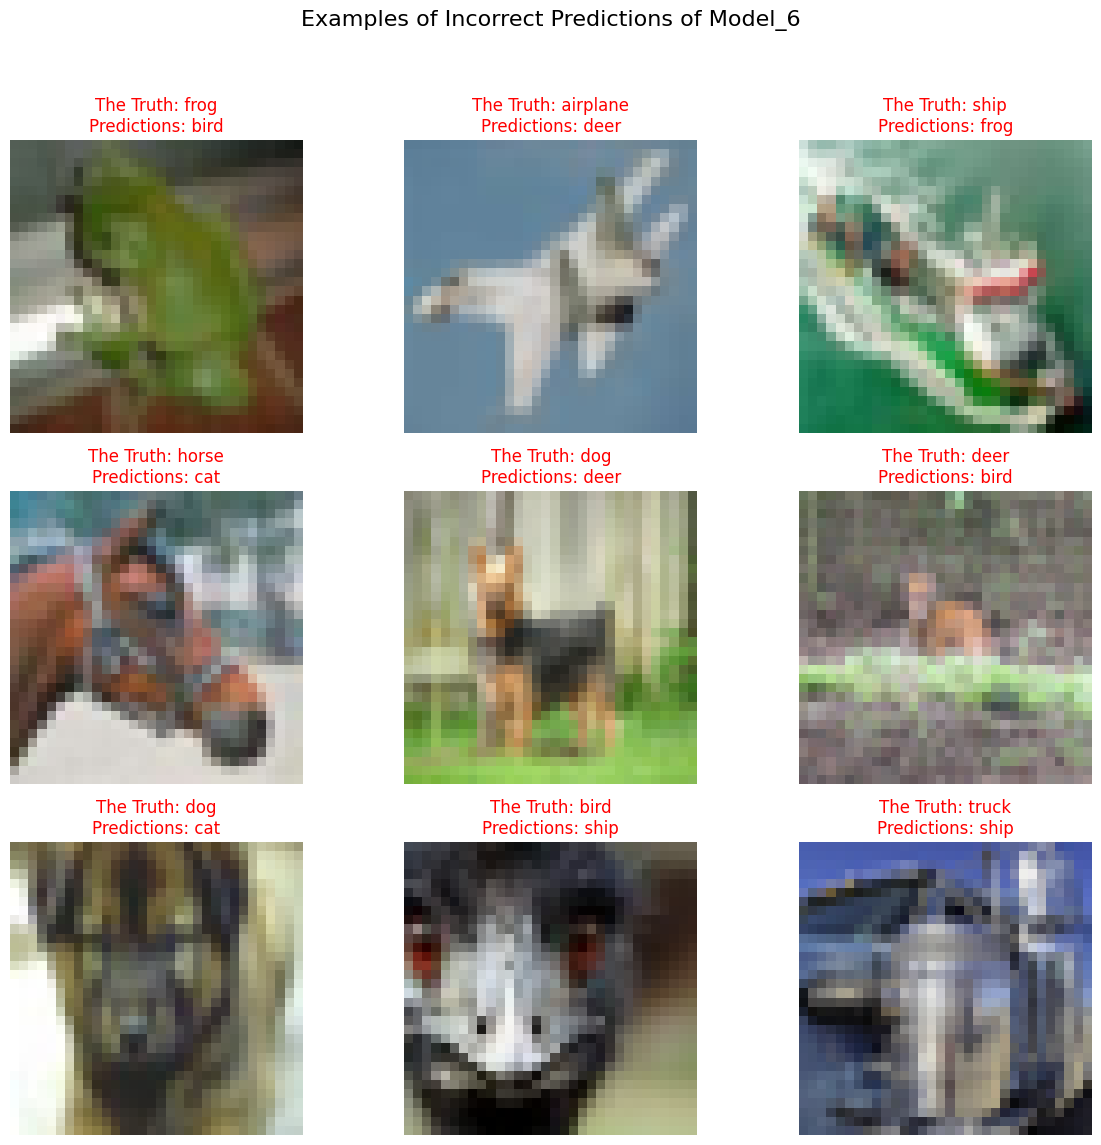

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np

incorrect_predictions = []

model_6.eval()
with torch.inference_mode():

    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        

        test_logits = model_6(X)
        test_preds = torch.argmax(test_logits, dim=1)
        

        incorrect_indices = torch.where(test_preds != y)[0]
        

        for idx in incorrect_indices:
            incorrect_predictions.append({
                "image": X[idx],
                "true_label": y[idx],
                "pred_label": test_preds[idx]
            })
         #Break the cycle if we have found enough examples (efficiency)
        if len(incorrect_predictions) >= 9:
            break


if len(incorrect_predictions) >= 9:
    pass 


plt.figure(figsize=(12, 12))
plt.suptitle("Examples of Incorrect Predictions of Model_6", fontsize=16)

for i, item in enumerate(incorrect_predictions[:9]):
    plt.subplot(3, 3, i+1)
    
   
    image_to_plot = item["image"].cpu()
    
    # IMPORTANT Correct colours by undoing normalisation
    image_to_plot = image_to_plot * 0.5 + 0.5
    
    #[C, H, W] -> [H, W, C] 
    plt.imshow(image_to_plot.permute(1, 2, 0))
    
   
    true_label_text = train_data.classes[item["true_label"]]
    pred_label_text = train_data.classes[item["pred_label"]]
    plt.title(f"The Truth: {true_label_text}\nPredictions: {pred_label_text}", color="red")
    
    plt.axis(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [36]:
import pandas as pd

results = [
    {"Model ID": "Model_0 (Dense)", "Test Accuracy": 49.22, "Overfitting Gap": "N/A (Underfitting)"},
    {"Model ID": "Model_1 (Dense, 2 layers)", "Test Accuracy": 51.31, "Overfitting Gap": "~12%"},
    {"Model ID": "Model_2 (Dense + Dropout)", "Test Accuracy": 51.79, "Overfitting Gap": "~10%"},
    {"Model ID": "Model_3 (CNN, 10 units)", "Test Accuracy": 67.33, "Overfitting Gap": "~1.5%"},
    {"Model ID": "Model_4 (CNN, 50 units)", "Test Accuracy": 73.75, "Overfitting Gap": "~14%"},
    {"Model ID": "Model_5 (CNN + Dropout)", "Test Accuracy": 75.62, "Overfitting Gap": "~14%"},
    {"Model ID": "Model_6 (CNN + BatchNorm)", "Test Accuracy": 77.22, "Overfitting Gap": "~13%"}
]

df_results = pd.DataFrame(results).set_index("Model ID")
display(df_results)

,Test Accuracy,Overfitting Gap
Model ID,,
Model_0 (Dense),49.22,N/A (Underfitting)
"Model_1 (Dense, 2 layers)",51.31,~12%
Model_2 (Dense + Dropout),51.79,~10%
"Model_3 (CNN, 10 units)",67.33,~1.5%
"Model_4 (CNN, 50 units)",73.75,~14%
Model_5 (CNN + Dropout),75.62,~14%
Model_6 (CNN + BatchNorm),77.22,~13%


# Save model_6

In [34]:
from pathlib import Path

MODEL_PATH=Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME="cifar10_cnn_model_with_batchnorm.pth"
MODEL_SAVE_PATH=MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_6.state_dict(),
           f=MODEL_SAVE_PATH)



Saving model to: models\cifar10_cnn_model_with_batchnorm.pth


## Loading the Saved Model and Making Predictions on a Single Image

In [51]:
image_url="https://media.istockphoto.com/id/175397603/photo/frog.jpg?s=612x612&w=0&k=20&c=EMXlwg5SicJllr7gnSFUUjzwCGa1ciLjYD1bk8NvO2E="
image_path = "_test_image.jpg"


# Download image
try: 
    with open(image_path,"wb") as f:
        request=requests.get(image_url)
        print(f"Downloading {image_path}")
        f.write(request.content)
except Exception as e:
    print(f"Could not download image {e}")




In [52]:
# Step 2: Create the Skeleton of the Model
loaded_model_6= CIFAR10ModelV_CNN_With_BN(input_shape=3,
                                          hidden_units=50,
    
    
                                          output_shape=10)
# Step 3: Load Saved Weights
model_state_dict=torch.load(f="models/cifar10_cnn_model_with_batchnorm.pth")
loaded_model_6.load_state_dict(model_state_dict)


# Send the model to the device (GPU)
loaded_model_6=loaded_model_6.to(device)


# Open the picture with PIL
image=Image.open(image_path)


# Define the same transformation here as we used in training.
# THIS STEP IS CRITICAL. Since the model is trained only in this format, it understands in this format

custom_image_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transformed_image=custom_image_transform(image)
# Add batch size: [C, H, W] -> [1, C, H, W]
image_with_batch_dim=transformed_image.unsqueeze(0)





C:\Users\sinan\AppData\Local\Temp\ipykernel_26896\4043388491.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict=torch.load(f="models/cifar10_cnn_model_with

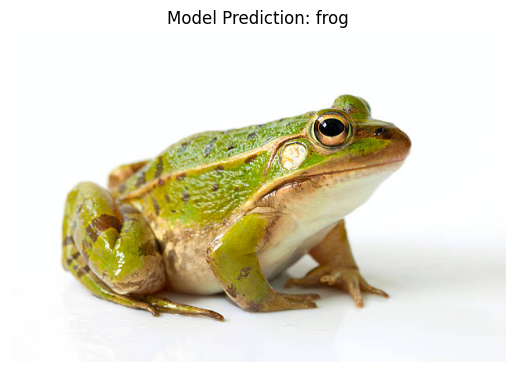

In [63]:
#Step 5: Make a Prediction

loaded_model_6.eval()
with torch.inference_mode():
    image_logits=loaded_model_6(image_with_batch_dim.to(device))
    image_pred_label=torch.argmax(image_logits,dim=1)


# Step 6: Comment and Show Result

class_names=train_data.classes
pred_class_name=class_names[image_pred_label.cpu()]

plt.imshow(image)
plt.title(f"Model Prediction: {pred_class_name}")
plt.axis(False)
plt.show()
